In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
import seaborn as sns

In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()

# drive = GoogleDrive(gauth)

# downloaded = drive.CreateFile({'id': '1S9Om604qmhb0XPFNFERGRY7-hWWeHJIt'})
# downloaded.GetContentFile('data_forecast.zip')

In [ ]:
# !unzip data_forecast.zip

### Initial data


In [ ]:
sales = pd.read_csv('sales.csv', delimiter=';',)
sales = sales.loc[:, ~sales.columns.str.contains('^Unnamed')]
sales['Sales'] = sales['Sales'].str.replace(' ', '').str.replace(',', '.').astype(float)
sales['Date'] = pd.to_datetime(sales['Date'], format='%d.%m.%Y')
sales.head()

,Shop,Date,Sales
0,1,2019-01-02,4739.45
1,2,2019-01-02,6254.80
2,3,2019-01-02,8710.77
3,4,2019-01-02,4389.85
4,5,2019-01-02,5119.37


Sales df (series):

- Shop: number of the shop (1-30)
- Date: date of the observation
- Sales: sales for a specific date

In [ ]:
shops = pd.read_csv('shop_data.csv', delimiter=';')
shops['City'] = shops['City'].str.extract('(\d+)').astype(int)
shops['Region'] = shops['Region'].str.extract('(\d+)').astype(int)
shops = shops.rename(columns={'Shop': 'shop_key'})
shops['Open_date'] = pd.to_datetime(shops['Open_date'], format='%d.%m.%Y')
shops['Trade_area'] = shops['Trade_area'].str.replace(',', '.').astype(float)
shops.head()

,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor
0,1,2018-10-04,NaN,36.04,15,1,sleeping quarters,bazaar,1
1,1,2021-12-20,Extension,48.05,15,1,sleeping quarters,bazaar,1
2,2,2018-01-12,NaN,30.93,8,2,periphery,supermarket,1
3,3,2018-02-16,NaN,36.94,27,3,centre,administrative institution,1
4,4,2018-01-22,NaN,17.42,7,4,sleeping quarters,supermarket,1


Shops df (additional information about shops):
- Shop: number of the shop (1-30)
- Open_date: date when the shop was opened
- Change_type: indicates whether the shop is being renovated or expanded
- Trade_area: area of the shop
- City: number of the city (1-30)
- Region: number of the region (1-30)
- City area: indicates the location of the store within the city (in the centre, in a residential area, on the periphery)
- Local_reference: indicate the type of nearby or surrounding location or facility associated with each shop
- Floor: floor on which the shop is located

### EDA shops

In [ ]:
sales.isnull().sum()

,0
Shop,0
Date,0
Sales,0


In [ ]:
sales['Sales'].describe()

,Sales
count,29425.000000
mean,15560.439518
std,11413.852390
min,0.000000
25%,7878.530000
50%,12363.840000
75%,19548.410000
max,90309.760000


In [ ]:
zero_sales_shops = sales[sales['Sales'] == 0]
result = zero_sales_shops.merge(shops[['shop_key', 'Open_date']], left_on='Shop', right_on='shop_key', how='left')
result['Date'] = pd.to_datetime(result['Date'], errors='coerce')
result['Open_date'] = pd.to_datetime(result['Open_date'], format='%d.%m.%Y', errors='coerce')
result[['Shop', 'Open_date', 'Date', 'Sales']]

,Shop,Open_date,Date,Sales
0,6,2019-03-27,2019-03-20,0.0
1,6,2019-03-27,2019-03-26,0.0
2,7,2019-07-23,2019-07-18,0.0
3,7,2019-07-23,2019-07-22,0.0
4,8,2019-10-10,2019-10-04,0.0
5,8,2019-10-10,2019-10-05,0.0
6,8,2019-10-10,2019-10-08,0.0
7,8,2019-10-10,2019-10-09,0.0
8,9,2019-11-19,2019-11-18,0.0
9,10,2020-01-29,2020-01-21,0.0


In [ ]:
shop_counts = sales['Shop'].value_counts().sort_index()
shop_counts

,count
Shop,
1,1722
2,1753
3,1758
4,1733
5,1699
6,1671
7,1560
8,1474
9,1430


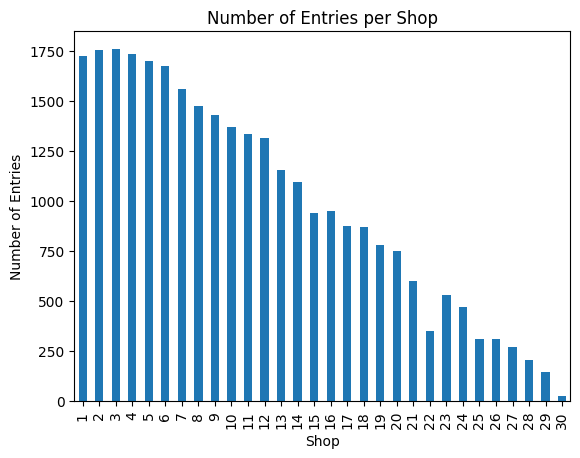

In [ ]:
shop_counts.plot(kind='bar', title='Number of Entries per Shop')
plt.xlabel('Shop')
plt.ylabel('Number of Entries')
plt.show()

In [ ]:
sales_by_shop = sales.pivot(index='Date', columns='Shop', values='Sales')
sales_by_shop.columns = [f'Sales{shop}' for shop in sales_by_shop.columns]
sales_by_shop = sales_by_shop.reset_index()

mean_sales = sales_by_shop.loc[:, sales_by_shop.columns != 'Date'].mean()
top_3_shops = mean_sales.sort_values(ascending=False).head(3)
top_3_shops

,0
Sales22,63402.229143
Sales18,30986.192414
Sales23,30198.960643


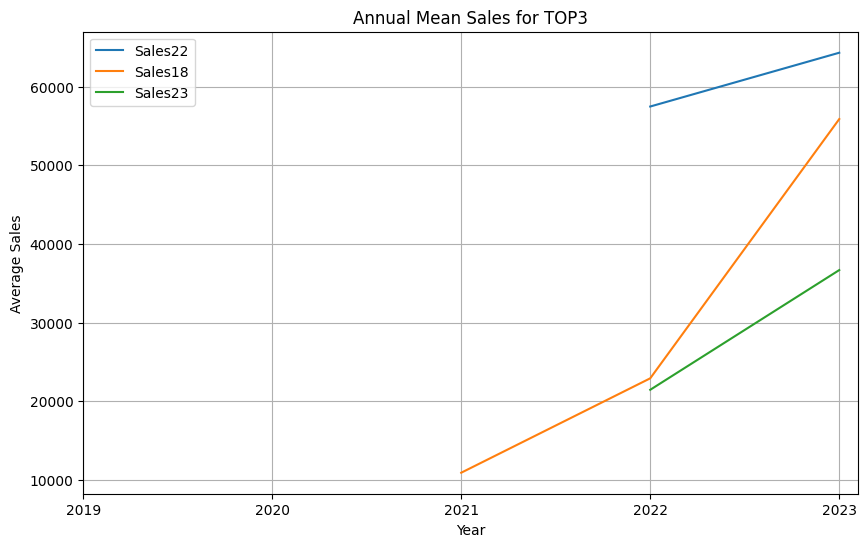

In [ ]:
def plot_mean_sales(df):
    top3_sh = ['Sales22', 'Sales18', 'Sales23']
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    means = df.groupby('Year')[top3_sh].mean()

    plt.figure(figsize=(10, 6))
    for col in top3_sh:
        plt.plot(means.index, means[col], label=col)
    plt.xticks(means.index)
    plt.xlabel("Year")
    plt.ylabel("Average Sales")
    plt.title("Annual Mean Sales for TOP3")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_mean_sales(sales_by_shop)

In [ ]:
top3 = ['Sales22', 'Sales18', 'Sales23']

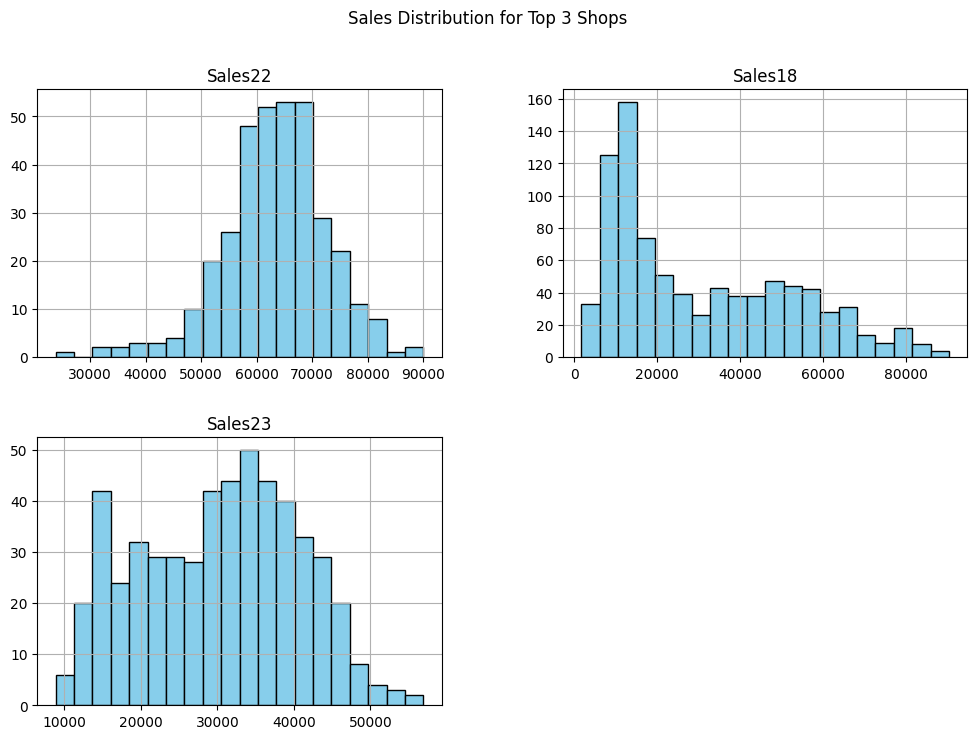

In [ ]:
sales_by_shop[top3].hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Sales Distribution for Top 3 Shops")
plt.show()

In [ ]:
sales_by_shop['Date'] = pd.to_datetime(sales_by_shop['Date'])
weekly_sales = sales_by_shop.set_index('Date')[top3].resample('W').sum()
monthly_sales = sales_by_shop.set_index('Date')[top3].resample('M').sum()

<ipython-input-15-b9f393b952f1>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = sales_by_shop.set_index('Date')[top3].resample('M').sum()


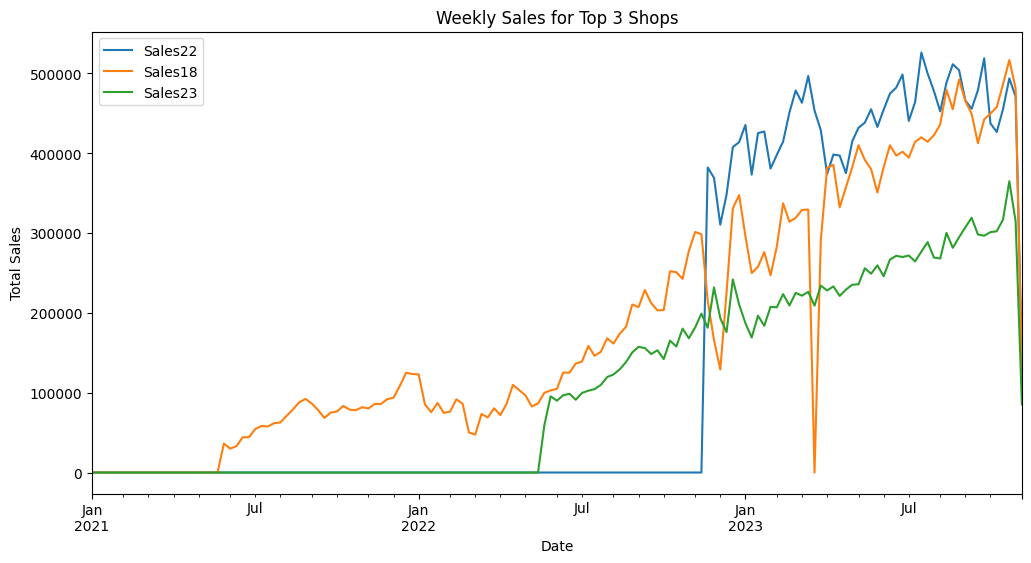

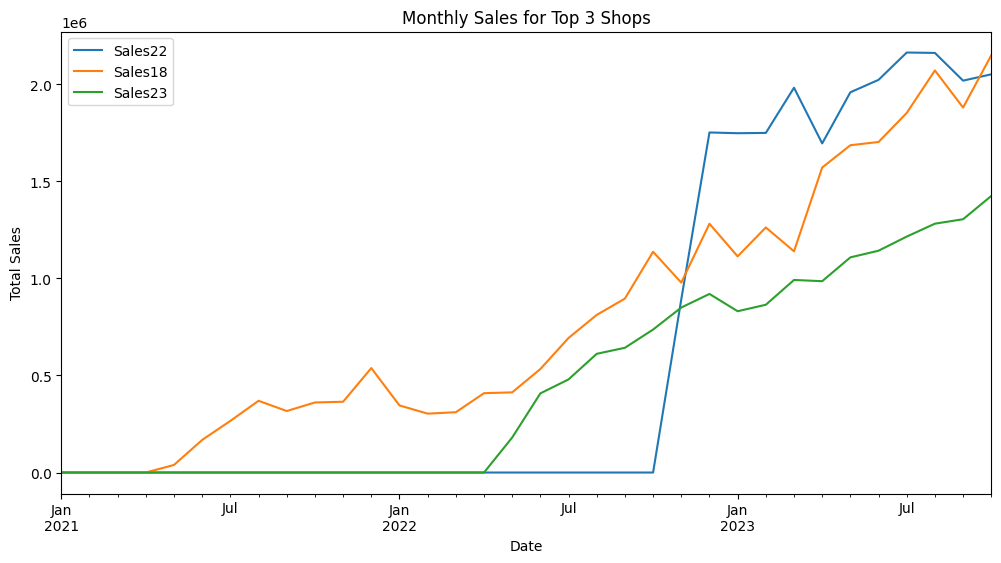

In [ ]:
weekly_sales = weekly_sales[weekly_sales.index >= '2021-01-01']
monthly_sales = monthly_sales[monthly_sales.index >= '2021-01-01']

weekly_sales.plot(figsize=(12, 6), title="Weekly Sales for Top 3 Shops")
plt.ylabel("Total Sales")
plt.show()

monthly_sales.plot(figsize=(12, 6), title="Monthly Sales for Top 3 Shops")
plt.ylabel("Total Sales")
plt.show()


### EDA additional data

In [ ]:
filtered_shops = shops[shops['shop_key'].isin([22, 18, 23])]
filtered_shops

,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor
19,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1
20,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2
25,22,2022-11-16,NaN,56.76,1,15,sleeping quarters,supermarket,1
26,23,2022-05-20,NaN,40.24,10,16,sleeping quarters,supermarket,1


- 18 shop had extensions
- all three shops are located in sleeping quarters (18 shop after extension - center)
- 18 shop are located near the bazaar, the other two near supermarkets
- all shops are located on the 1st floor (18 shop after extension - 2nd floor)
- the average trade area is 48.

Overall, we have 30 shops, so let`s look how many shops are located in different ciry area.

In [ ]:
filtered_city_area_counts = shops[shops['Change_type'].isna()]['City area'].value_counts()
filtered_city_area_counts

,count
City area,
sleeping quarters,17
centre,10
periphery,3


Next, we decided to select one shop to use in the forecasting models.
Firstly, we combined two categories (city_area and local_reference).

In [ ]:
grouped_counts = shops.groupby(['City area', 'Local_reference'])['shop_key'].nunique().reset_index()
grouped_counts.columns = ['City area', 'Local reference', 'Count']
for city_area in grouped_counts['City area'].unique():
    print(f"City area: {city_area}")
    subset = grouped_counts[grouped_counts['City area'] == city_area]
    for _, row in subset.iterrows():
        print(f"  Local reference: {row['Local reference']} | Count: {row['Count']}")
    print()

City area: centre
  Local reference: administrative institution | Count: 2
  Local reference: bazaar | Count: 6
  Local reference: centre | Count: 2
  Local reference: railway station | Count: 2

City area: periphery
  Local reference: supermarket | Count: 3

City area: sleeping quarters
  Local reference: bazaar | Count: 9
  Local reference: educational institution | Count: 1
  Local reference: supermarket | Count: 8



Here we see that the most frequent pair is - sleeping quarter and bazzar. So, let`s filter such shops and calculate their mean sales.

In [ ]:
sleeping_bazaar = shops[(shops['City area'] == 'sleeping quarters') & (shops['Local_reference'] == 'bazaar')]
sleeping_bazaar

,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor
0,1,2018-10-04,NaN,36.04,15,1,sleeping quarters,bazaar,1
1,1,2021-12-20,Extension,48.05,15,1,sleeping quarters,bazaar,1
6,6,2019-03-27,NaN,32.13,4,3,sleeping quarters,bazaar,2
10,10,2020-01-29,NaN,30.03,25,7,sleeping quarters,bazaar,2
11,11,2020-02-21,NaN,31.23,12,8,sleeping quarters,bazaar,1
14,13,2021-02-08,Extension,45.95,18,7,sleeping quarters,bazaar,1
16,15,2021-02-21,NaN,47.75,21,10,sleeping quarters,bazaar,1
19,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1
23,20,2021-10-11,NaN,49.25,13,12,sleeping quarters,bazaar,1
31,27,2023-02-06,NaN,51.05,22,17,sleeping quarters,bazaar,1


In [ ]:
shop_keys_to_include = [1, 6, 10, 11, 13, 15, 18, 20, 27]

filtered_sales = sales[sales['Shop'].isin(shop_keys_to_include)]

mean_sales_per_shop = filtered_sales.groupby('Shop')['Sales'].mean().reset_index()
mean_sales_per_shop.columns = ['Shop', 'Mean_sales']

sorted_mean_sales = mean_sales_per_shop.sort_values(by='Mean_sales', ascending=False).reset_index(drop=True)
sorted_mean_sales

,Shop,Mean_sales
0,18,30986.192414
1,13,22548.046970
2,27,22497.860075
3,6,17345.058163
4,10,16381.868596
5,1,9974.790186
6,15,9800.825628
7,20,9247.831653
8,11,8339.170420


**18 shop** is located in sleeping qurter near bazaar and has the biggest sale amount among other shops.

In [ ]:
shop_18_sales = sales[sales['Shop'] == 18]
shop_18_sales

,Shop,Date,Sales
8866,18,2021-05-24,5218.92
8883,18,2021-05-25,5964.11
8900,18,2021-05-26,4206.46
8917,18,2021-05-27,4833.18
8934,18,2021-05-28,3942.94
...,...,...,...
29292,18,2023-10-27,68384.05
29322,18,2023-10-28,82875.86
29352,18,2023-10-29,79778.86
29382,18,2023-10-30,59995.35


In [ ]:
shop_18_add_info = shops[shops['shop_key'] == 18]
shop_18_add_info

,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor
19,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1
20,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2


Merge

In [ ]:
shops = shops.sort_values(by=['shop_key', 'Open_date']).reset_index(drop=True)

max_sales_date = sales['Date'].max()
shops['End_date'] = shops.groupby('shop_key')['Open_date'].shift(-1)
shops['End_date'].fillna(max_sales_date, inplace=True)

merged_data = sales.merge(shops, left_on='Shop', right_on='shop_key', how='left')

merged_data = merged_data[(merged_data['Date'] >= merged_data['Open_date']) &
                          (merged_data['Date'] <= merged_data['End_date'])]

shop_18_data = merged_data[merged_data['shop_key'] == 18]
shop_18_data

<ipython-input-24-8c884e63c4d1>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shops['End_date'].fillna(max_sales_date, inplace=True)


,Shop,Date,Sales,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor,End_date
9998,18,2021-05-24,5218.92,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10018,18,2021-05-25,5964.11,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10038,18,2021-05-26,4206.46,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10058,18,2021-05-27,4833.18,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10078,18,2021-05-28,3942.94,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34100,18,2023-10-27,68384.05,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31
34135,18,2023-10-28,82875.86,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31
34170,18,2023-10-29,79778.86,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31
34205,18,2023-10-30,59995.35,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31


In [ ]:
shop_18_data

,Shop,Date,Sales,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor,End_date
9998,18,2021-05-24,5218.92,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10018,18,2021-05-25,5964.11,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10038,18,2021-05-26,4206.46,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10058,18,2021-05-27,4833.18,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
10078,18,2021-05-28,3942.94,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34100,18,2023-10-27,68384.05,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31
34135,18,2023-10-28,82875.86,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31
34170,18,2023-10-29,79778.86,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31
34205,18,2023-10-30,59995.35,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31


Feature engeneering

In [ ]:
shop_18_data['Year'] = shop_18_data['Date'].dt.year
shop_18_data['Month'] = shop_18_data['Date'].dt.month
shop_18_data['Day'] = shop_18_data['Date'].dt.day
shop_18_data['Day_of_Week'] = shop_18_data['Date'].dt.dayofweek
shop_18_data['Week_of_Year'] = shop_18_data['Date'].dt.isocalendar().week
shop_18_data

<ipython-input-26-306fdad76a3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_18_data['Year'] = shop_18_data['Date'].dt.year
<ipython-input-26-306fdad76a3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_18_data['Month'] = shop_18_data['Date'].dt.month
<ipython-input-26-306fdad76a3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,Shop,Date,Sales,shop_key,Open_date,Change_type,Trade_area,City,Region,City area,Local_reference,Floor,End_date,Year,Month,Day,Day_of_Week,Week_of_Year
9998,18,2021-05-24,5218.92,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23,2021,5,24,0,21
10018,18,2021-05-25,5964.11,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23,2021,5,25,1,21
10038,18,2021-05-26,4206.46,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23,2021,5,26,2,21
10058,18,2021-05-27,4833.18,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23,2021,5,27,3,21
10078,18,2021-05-28,3942.94,18,2021-05-24,NaN,45.95,14,13,sleeping quarters,bazaar,1,2023-03-23,2021,5,28,4,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34100,18,2023-10-27,68384.05,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31,2023,10,27,4,43
34135,18,2023-10-28,82875.86,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31,2023,10,28,5,43
34170,18,2023-10-29,79778.86,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31,2023,10,29,6,43
34205,18,2023-10-30,59995.35,18,2023-03-23,Extension,61.26,14,13,centre,bazaar,2,2023-10-31,2023,10,30,0,44


In [ ]:
# weekend_data = shop_18_data[shop_18_data['Day_of_Week'].isin([5, 6])]

# unique_sales_values = weekend_data['Sales'].unique()
# unique_sales_values


In [ ]:
shop_18_data['Time_Since_Open'] = (shop_18_data['Date'] - shop_18_data['Open_date']).dt.days

<ipython-input-28-43d1ce57e947>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shop_18_data['Time_Since_Open'] = (shop_18_data['Date'] - shop_18_data['Open_date']).dt.days


In [ ]:
shop_18_data.columns

Index(['Shop', 'Date', 'Sales', 'shop_key', 'Open_date', 'Change_type',
       'Trade_area', 'City', 'Region', 'City area', 'Local_reference', 'Floor',
       'End_date', 'Year', 'Month', 'Day', 'Day_of_Week', 'Week_of_Year',
       'Time_Since_Open'],
      dtype='object')

In [ ]:
# shop_18_data['Local_reference'].unique()

In [ ]:
shop_18_data['Floor'].unique()

array([1, 2])

In [ ]:
categorical_columns = ['Change_type', 'City area', 'Local_reference', 'Floor']
shop_18_data_with_dummies = pd.get_dummies(shop_18_data, columns=categorical_columns, drop_first=True)
shop_18_data_with_dummies.fillna(0, inplace=True)
shop_18_data_with_dummies

,Shop,Date,Sales,shop_key,Open_date,Trade_area,City,Region,End_date,Year,Month,Day,Day_of_Week,Week_of_Year,Time_Since_Open,City area_sleeping quarters,Floor_2
9998,18,2021-05-24,5218.92,18,2021-05-24,45.95,14,13,2023-03-23,2021,5,24,0,21,0,True,False
10018,18,2021-05-25,5964.11,18,2021-05-24,45.95,14,13,2023-03-23,2021,5,25,1,21,1,True,False
10038,18,2021-05-26,4206.46,18,2021-05-24,45.95,14,13,2023-03-23,2021,5,26,2,21,2,True,False
10058,18,2021-05-27,4833.18,18,2021-05-24,45.95,14,13,2023-03-23,2021,5,27,3,21,3,True,False
10078,18,2021-05-28,3942.94,18,2021-05-24,45.95,14,13,2023-03-23,2021,5,28,4,21,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34100,18,2023-10-27,68384.05,18,2023-03-23,61.26,14,13,2023-10-31,2023,10,27,4,43,218,False,True
34135,18,2023-10-28,82875.86,18,2023-03-23,61.26,14,13,2023-10-31,2023,10,28,5,43,219,False,True
34170,18,2023-10-29,79778.86,18,2023-03-23,61.26,14,13,2023-10-31,2023,10,29,6,43,220,False,True
34205,18,2023-10-30,59995.35,18,2023-03-23,61.26,14,13,2023-10-31,2023,10,30,0,44,221,False,True


In [ ]:
correlation_columns = [
    'Sales', 'Trade_area', 'Year', 'Month', 'Day',
    'Day_of_Week', 'Week_of_Year', 'Time_Since_Open',
    'City area_sleeping quarters', 'Floor_2'
]
correlation_matrix = shop_18_data_with_dummies[correlation_columns].corr()

In [ ]:
sales_correlation = correlation_matrix['Sales'].sort_values(ascending=False)
print("Correlations with Sales:")
sales_correlation

Correlations with Sales:


,Sales
Sales,1.000000
Year,0.812994
Trade_area,0.789978
Floor_2,0.789978
Day_of_Week,0.182507
Month,0.066681
Week_of_Year,0.059022
Day,0.031468
Time_Since_Open,0.019266
City area_sleeping quarters,-0.789978


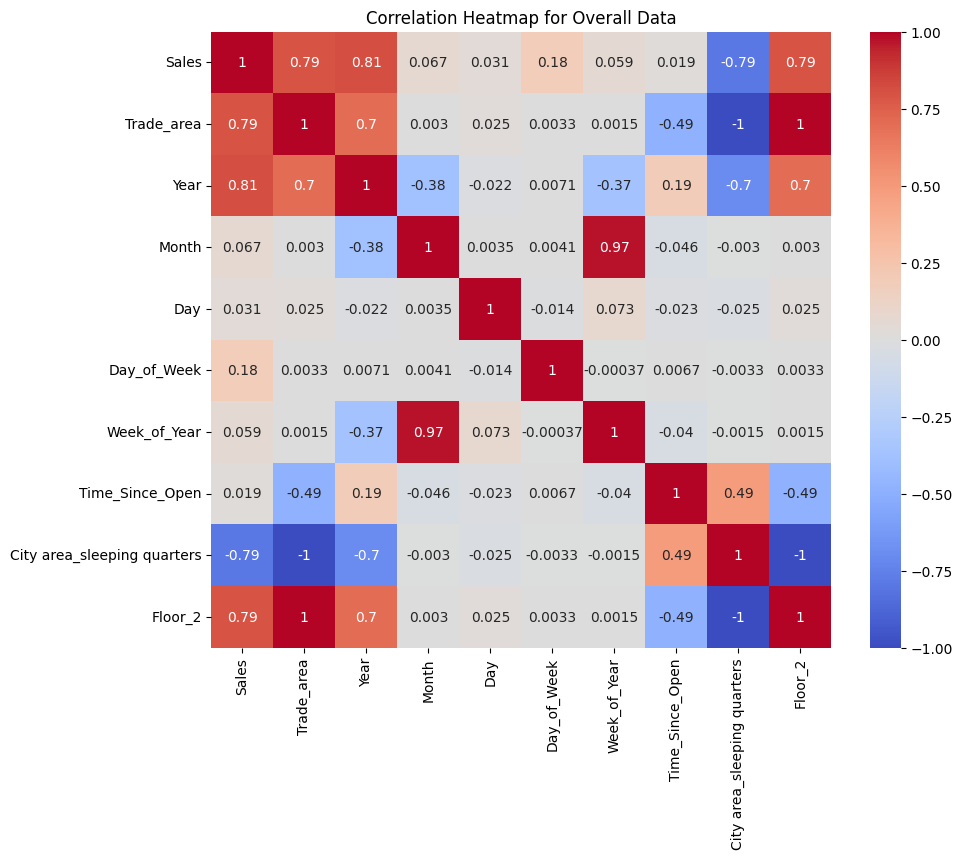

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Overall Data')
plt.show()


### Some more additional data

Daily number of alarms in Ukraine

In [ ]:
alarm_kyiv = pd.read_csv('alarms-daily-kyiv-240222-041124.csv', delimiter=';')
alarm_ukraine = pd.read_csv('alarms-daily-by-regions-240222-041124.csv', delimiter=';')
alarm_kyiv = alarm_kyiv.drop(columns=['reg_id', 'official_title_uk'])
alarm_ukraine = alarm_ukraine.drop(columns=['reg_id', 'official_title_uk'])
alarm_ukraine = alarm_ukraine.groupby('alarms_date').sum()
alarm_df = pd.merge(alarm_kyiv, alarm_ukraine, left_on='alarms_date', right_index=True)
alarm_df['alarms_quantity'] = alarm_df['alarms_quantity_x'] + alarm_df['alarms_quantity_y']
alarm_df = alarm_df.drop(columns=['alarms_quantity_x', 'alarms_quantity_y'])
alarm_df['alarms_date'] = pd.to_datetime(alarm_df['alarms_date'])
alarm_df = alarm_df.rename(columns={'alarms_date': 'Date'})
alarm_df.head()

,Date,alarms_quantity
0,2022-02-24,4
1,2022-02-25,22
2,2022-02-26,46
3,2022-02-27,65
4,2022-02-28,79


Cost of fuel

In [ ]:
fuel = pd.read_csv('fuel.csv', delimiter=';')
fuel['Diesel'] = fuel['Diesel'].str.replace(',', '.').astype(float)
fuel['Date'] = pd.to_datetime(fuel['Date'], format='%d.%m.%Y')
fuel.head()

,Date,Diesel
0,2019-01-02,29.10
1,2019-01-03,29.08
2,2019-01-04,29.04
3,2019-01-08,28.59
4,2019-01-09,28.57


In [ ]:
events = pd.read_csv('events.csv', delimiter=';')
events['Date_start'] = pd.to_datetime(events['Date_start'], format='%d.%m.%Y')
events['Date_end'] = pd.to_datetime(events['Date_end'], format='%d.%m.%Y')
events.head()

,Date_start,Date_end,Type,Event
0,2019-02-22,2019-02-23,Promotion,Promo1
1,2019-10-25,2019-10-25,Promotion,Halloween
2,2019-11-29,2019-12-01,Promotion,Black Friday
3,2020-02-21,2020-02-22,Promotion,Promo1
4,2020-03-16,2020-05-11,Lockdown,Hard lockdown


In [ ]:
rates = pd.read_csv('exchange_rates.csv')

usd_rates = rates[rates['Letter code'] == 'USD'][['Date', 'Official hrivnya exchange rates, UAH']].rename(columns={'Official hrivnya exchange rates, UAH': 'USD'})
eur_rates = rates[rates['Letter code'] == 'EUR'][['Date', 'Official hrivnya exchange rates, UAH']].rename(columns={'Official hrivnya exchange rates, UAH': 'EUR'})
exchange_rates = pd.merge(usd_rates, eur_rates, on='Date', how='inner')

exchange_rates['USD'] = round(exchange_rates['USD'], 2)
exchange_rates['EUR'] = round(exchange_rates['EUR'], 2)

exchange_rates_final = exchange_rates[['Date', 'USD', 'EUR']]
exchange_rates_final['Date'] = pd.to_datetime(exchange_rates_final['Date'], format='%d.%m.%Y')

exchange_rates = exchange_rates_final[exchange_rates_final['Date'] >= '2019-01-01']
exchange_rates.head()

,Date,USD,EUR
365,2019-01-01,2768.83,3171.41
366,2019-01-02,2768.83,3171.41
367,2019-01-03,2768.83,3171.41
368,2019-01-04,2751.17,3122.03
369,2019-01-05,2751.17,3122.03


Add to our 18 shop dataset

In [ ]:
shop_18_data_with_dummies = pd.merge(
    shop_18_data_with_dummies,
    alarm_df[['Date', 'alarms_quantity']],
    on='Date',
    how='left'
)

shop_18_data_with_dummies = pd.merge(
    shop_18_data_with_dummies,
    fuel[['Date', 'Diesel']],
    on='Date',
    how='left'
)

shop_18_data_with_dummies = pd.merge(
    shop_18_data_with_dummies,
    exchange_rates_final[['Date', 'USD', 'EUR']],
    on='Date',
    how='left'
)
shop_18_data_with_dummies

,Shop,Date,Sales,shop_key,Open_date,Trade_area,City,Region,End_date,Year,...,Day,Day_of_Week,Week_of_Year,Time_Since_Open,City area_sleeping quarters,Floor_2,alarms_quantity,Diesel,USD,EUR
0,18,2021-05-24,5218.92,18,2021-05-24,45.95,14,13,2023-03-23,2021,...,24,0,21,0,True,False,NaN,27.35,27.46,33.48
1,18,2021-05-25,5964.11,18,2021-05-24,45.95,14,13,2023-03-23,2021,...,25,1,21,1,True,False,NaN,27.35,27.43,33.49
2,18,2021-05-26,4206.46,18,2021-05-24,45.95,14,13,2023-03-23,2021,...,26,2,21,2,True,False,NaN,27.33,27.46,33.66
3,18,2021-05-27,4833.18,18,2021-05-24,45.95,14,13,2023-03-23,2021,...,27,3,21,3,True,False,NaN,27.35,27.55,33.68
4,18,2021-05-28,3942.94,18,2021-05-24,45.95,14,13,2023-03-23,2021,...,28,4,21,4,True,False,NaN,27.34,27.53,33.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,18,2023-10-27,68384.05,18,2023-03-23,61.26,14,13,2023-10-31,2023,...,27,4,43,218,False,True,34.0,55.67,36.51,38.47
867,18,2023-10-28,82875.86,18,2023-03-23,61.26,14,13,2023-10-31,2023,...,28,5,43,219,False,True,67.0,NaN,36.51,38.47
868,18,2023-10-29,79778.86,18,2023-03-23,61.26,14,13,2023-10-31,2023,...,29,6,43,220,False,True,72.0,NaN,36.51,38.47
869,18,2023-10-30,59995.35,18,2023-03-23,61.26,14,13,2023-10-31,2023,...,30,0,44,221,False,True,63.0,55.69,36.42,38.38


In [ ]:
correlation_columns2 = [
    'Sales', 'Trade_area', 'Year', 'Month', 'Day', 'Day_of_Week', 'Week_of_Year',
    'Time_Since_Open', 'City area_sleeping quarters', 'Floor_2',
    'alarms_quantity', 'Diesel', 'USD', 'EUR'
]

correlation_matrix2 = shop_18_data_with_dummies[correlation_columns2].corr()

In [ ]:
sales_correlation2 = correlation_matrix2['Sales'].sort_values(ascending=False)
print("Correlations with Sales:")
sales_correlation2

Correlations with Sales:


,Sales
Sales,1.000000
EUR,0.837380
Year,0.812994
USD,0.807070
Trade_area,0.789978
Floor_2,0.789978
Diesel,0.605266
Day_of_Week,0.182507
Month,0.066681
Week_of_Year,0.059022


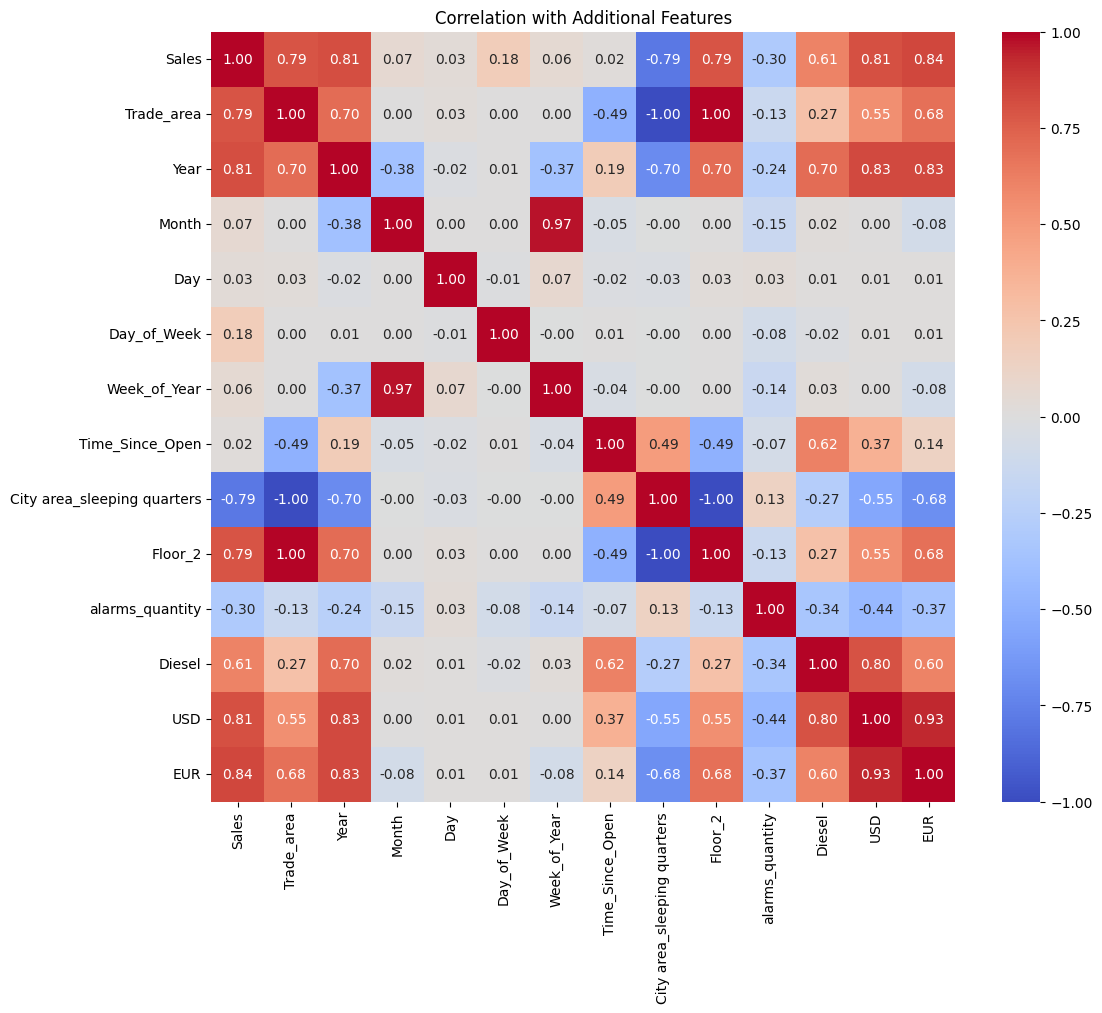

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with Additional Features')
plt.show()